In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pprint
from cohorts.functions import *
import lifelines as ll
import patsy
import functools
import survivalstan
from cohorts.utils import strip_column_names
%matplotlib inline

In [2]:
## set seeds for stan & rngs, to aid in reproducibility
## (note: only reproducible within a machine, not across machines)

seed = 91038753
import random
random.seed(seed)

In [3]:
from utils import data
from utils import paper
from utils.extra_functions import *

# prep data 

## load data

In [4]:
cohort = data.init_cohort(join_with=["ensembl_coverage","tcr_peripheral_a"])

inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows


inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows
{'dataframe_hash': 7698303973572390439,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}


In [5]:
def tcell_fraction(row):
    return row["T-cell fraction"]

def peripheral_clonality_a(row):
    return row['Clonality']

cols, d = cohort.as_dataframe([snv_count,
                               missense_snv_count,
                               neoantigen_count,
                               expressed_exonic_snv_count,
                               expressed_missense_snv_count,
                               expressed_neoantigen_count,
                               exonic_snv_count,
                               peripheral_clonality_a,
                               tcell_fraction,
                               ],
                              rename_cols=True,
                              return_cols=True)

inner join with tcr_peripheral_a: 25 to 25 rows
inner join with ensembl_coverage: 25 to 25 rows


inner join with ensembl_coverage: 25 to 25 rows


In [6]:
cols

['snv_count',
 'missense_snv_count',
 'neoantigen_count',
 'expressed_exonic_snv_count',
 'expressed_missense_snv_count',
 'expressed_neoantigen_count',
 'exonic_snv_count',
 'peripheral_clonality_a',
 'tcell_fraction']

## construct/rescale variables

In [7]:
## add/modify count variables
d['nonexonic_snv_count'] = d.snv_count - d.exonic_snv_count
cols.append('nonexonic_snv_count')

In [8]:
## create 'observed', log-transformed & centered versions of variables (not normalized by MB)
for col in cols:
    observed_col = 'observed_{}'.format(col)
    log_col = 'log_{}'.format(col)
    log_col_centered = 'log_{}_centered'.format(col)
    log_col_rescaled = 'log_{}_rescaled'.format(col)
    d[observed_col] = d[col]*d['mb']
    d[log_col] = np.log1p(d[observed_col])
    d[log_col_centered] = d[log_col] - np.mean(d[log_col])
    d[log_col_rescaled] = d[log_col_centered]/np.std(d[log_col_centered])

## save key vars in list for future use
vars_centered = ['log_{}_centered'.format(col) for col in cols]
vars_rescaled = ['log_{}_rescaled'.format(col) for col in cols]

In [9]:
## construct new variables for key ratios / comparisons

# what proportion of X are expressed?
d['exonic_expression_ratio'] = d.expressed_exonic_snv_count / d.exonic_snv_count
d['missense_expression_ratio'] = d.expressed_missense_snv_count / d.missense_snv_count
d['neoantigen_expression_ratio'] = d.expressed_neoantigen_count / d.neoantigen_count

# d['expressed_missense2snv_ratio'] = d.expressed_missense_snv_count / d.expressed_snv_count
d['missense2exonic_snv_ratio'] = d.missense_snv_count / d.exonic_snv_count
d['expressed_neoantigen2missense_ratio'] = d.expressed_neoantigen_count / d.expressed_missense_snv_count

extra_cols = ['missense_expression_ratio','neoantigen_expression_ratio', 'exonic_expression_ratio', 'missense2exonic_snv_ratio','expressed_neoantigen2missense_ratio']
## create recentered versions of ratios
for col in extra_cols:
    col_centered = '{}_centered'.format(col)
    col_rescaled = '{}_rescaled'.format(col)
    d[col_centered] = d[col] - np.mean(d[col])
    d[col_rescaled] = d[col_centered]/np.std(d[col_centered])

## append extra-cols to key var lists
vars_centered.extend(['{}_centered'.format(col) for col in extra_cols])
vars_rescaled.extend(['{}_rescaled'.format(col) for col in extra_cols])


## center variables by mean within PD-L1 group

In [10]:
## identify list of variables to center
metrics = list(cols)
metrics.extend(extra_cols)


In [11]:
metrics2 = list(metrics)
metrics2.extend(['pd_l1'])
assert(not 'pd_l1' in metrics)
log_metrics2 = ['log_{}'.format(var) for var in metrics2]
metrics2.extend(log_metrics2)

In [12]:
grp_metrics = [var for var in metrics2 if var in d.columns]

In [13]:
# center variables by group
bygrp = d.loc[:, grp_metrics]
bygrp = bygrp.groupby('pd_l1').transform(lambda x: x - x.mean())
bygrp['patient_id'] = d.patient_id

In [14]:
# merge recentered variables back into original dataframe
df = pd.merge(d, bygrp, on = 'patient_id', suffixes = ['', '_centered_by_pd_l1'])

# prep data for survival analysis (long format)

In [15]:
## prep dflong_pfs which will be used for survival analysis using stan
df_long_pfs = survivalstan.prep_data_long_surv(df = df,
                                               event_col = 'is_progressed_or_deceased',
                                               time_col = 'pfs')

# multivariate analysis using varying-coef model

In [16]:
models = survivalstan.utils.read_files('../utils/stan')

../utils/stan/logistic_model.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_expressed_missense_and_neoant_mutations.stan
../utils/stan/logistic_model_by_group.stan
../utils/stan/pem_survival_model_unstructured_varcoef.stan
../utils/stan/pem_survival_model_unstructured_varcoef_hsprior.stan
../utils/stan/pem_survival_model_randomwalk_tvc.stan
../utils/stan/pem_survival_model_randomwalk_alt.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi.stan
../utils/stan/pem_survival_model_varying_coefs3.stan
../utils/stan/pem_survival_model_randomwalk.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_rate_only.stan
../utils/stan/pem_survival_model_gamma.stan
../utils/stan/pem_survival_model_randomwalk_custom_coefs_missense_and_neoant_rates.stan
../utils/stan/pem_survival_model_randomwalk_tvc2.stan
../utils/stan/pem_survival_model_varying_coefs2.stan
../utils/stan/pem_survival_model_varying_coefs4.stan
../utils/stan/pem_survival_model_randomwalk_bspline_est_xi2

In [17]:
survstan_pfs_varcoef = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_pfs,
    model_code = models['pem_survival_model_unstructured_varcoef.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    )


## summarize varying-coef model for missense_snv_count by liver-mets

In [18]:
livermet = survstan_pfs_varcoef(formula = 'log_missense_snv_count_centered', 
                               group_col = 'liver_mets',
                              )

NOT reusing model.


Ran in 91.687 sec.


/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


{{{hr_missense_by_livermet_pfs}}}


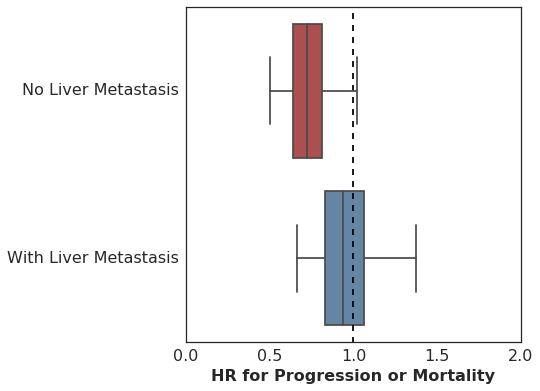

In [19]:
paper.hyper_figure_label_printer('hr_missense_by_livermet_pfs')
sb.boxplot(data=livermet['grp_coefs'], x='exp(beta)', y='group', fliersize=0, whis=[2.5, 97.5])
_ = plt.xlim([0, 2])
_ = plt.vlines(1, -10, 10, linestyles='--')
#_ = plt.title('Hazard associated with log(missense SNV count / MB) \n by liver-met status')
_ = plt.ylabel('')
_ = plt.xlabel('HR for {}'.format(cohort.hazard_plot_name))
_ = plt.yticks([0, 1], ['No Liver Metastasis','With Liver Metastasis'])

In [20]:
livermet['grp_coefs']['group_label'] = livermet['grp_coefs'].group.apply(
    lambda x: 'hr_missense_pfs_livermet_{}'.format(x)
)
for (name, livermet_class), group in livermet['grp_coefs'].groupby(['group_label','group']):
    group_n = len(df.loc[df.liver_mets==livermet_class, 'liver_mets'])
    paper.hyper_label_printer(formatter=paper.hr_posterior_formatter,
                              label=name,
                              n=group_n,
                              series=group['exp(beta)'])

{{{hr_missense_pfs_livermet_0:n=16, HR=0.73, 95% CI (0.50, 1.02)}}}
{{{hr_missense_pfs_livermet_1:n=9, HR=0.96, 95% CI (0.66, 1.37)}}}


In [21]:
## bayesian p-value for interaction
comparison2 = pd.pivot_table(livermet['grp_coefs'],
                  index = ['iter', 'model_cohort', 'variable'],
                  values = 'value', columns = 'group_label')
pval=1-(comparison2.eval('hr_missense_pfs_livermet_0 < hr_missense_pfs_livermet_1').mean())
print('{{{%s:%s}}}' % ('pval_missense_pfs_interaction_livermet',
                       paper.float_str(pval)))

{{{pval_missense_pfs_interaction_livermet:0.14}}}
